In [228]:
from typing import Iterator, Protocol
import QuantLib as ql
import numpy as np
import matplotlib.pyplot as plt


AUD = ql.AUDCurrency()


class Asset(Protocol):
    def price(self, market: Iterator[float]) -> Iterator[float]:
        ...

    # this corresponds with the length of Asset.price
    def duration(self) -> int | None:
        ...


    def name(self) -> str:
        ...

class Market:
    returns: float
    std: float
    first_price: float

    def __init__(self, returns = 0.12, std = 0.2, first_price = 1) -> None:
        self.returns = returns
        self.std = std
        self.first_price = first_price

    def duration(self) -> int | None:
        return None

    
    def price(self) -> Iterator[float]:
        price = self.first_price
        yield price

        # infinite market duration
        while True:
            # assume a normal distribution of the return, N(returns, std^2)
            ret = np.random.normal(self.returns, self.std)
            price = price * (1 + ret)
            yield price


    def name(self) -> str:
        return 'ASX'
        
class Equity:
    # systematic risk
    beta: float
    # unsystematic risk
    std: float
    first_price: float
    risk_free: float

    alias: str = 'equity'

    def __init__(self,
        risk_free: float,
        beta: float = 1, 
        std: float = 0.55,
        first_price: float = 1
    ) -> None:
        self.risk_free = risk_free
        self.beta = beta
        self.std = std
        self.first_price = first_price


    def price(self, market: Iterator[float]) -> Iterator[float]:
        price = self.first_price
        yield price

        market_last = next(market)
        for market_price in market:
            ret = (market_price / market_last) - 1

            # compute new return
            rate = self.beta * ret + np.random.normal(self.risk_free, self.std)
            price = price * (1+rate)
            yield price

            market_last = market_price

    
    def name(self):
        return self.alias
    


class Graphing:
    assets: list[Asset]
    market: Market

    def __init__(self, market: Market, assets: list[Asset]) -> None:
        self.market = market
        self.assets = assets

    
    def show(self, duration: int, repeat: int = 1):
        xs = np.arange(0, duration)

        fig = plt.figure(figsize=(12,6))
        ax = plt.gca()

        op = 1 if repeat == 1 else 0.1
        for r in range(repeat):
            # compute market return
            prices = []
            it = self.market.price()
            for i in range(duration):
                try:
                    price = next(it)
                    prices.append(price)
                except StopIteration:
                    break

            ax.plot(xs, prices,linewidth=2, alpha=op, label='ASX' if repeat == 1 else None)

            # compute asset returns
            portfolio = []
            assets = len(self.assets)
            iters = list(map(lambda a: a.price(iter(prices)), self.assets))
            values = list(map(lambda _: [], range(assets)))

            for i, price in zip(range(duration), prices):
                portfolio.append(0)
                for id in range(assets):
                    value = next(iters[id])
                    values[id].append(value)
                    portfolio[i] += value / assets

            for id in range(assets):
                ax.plot(xs, values[id], alpha=op, label=self.assets[id].name() if repeat == 1 else None)            
            
            ax.plot(xs, portfolio, label=f"portfolio {r+1}")
        
        # ax.set_yscale('log')
        ax.set_xlabel('Periods')
        ax.set_ylabel('Asset Price / $AUD')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_ylim(0.6, 4)
        plt.grid()
        fig.show()


C:\Users\forti\AppData\Local\Temp\ipykernel_44964\3084116294.py:147: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


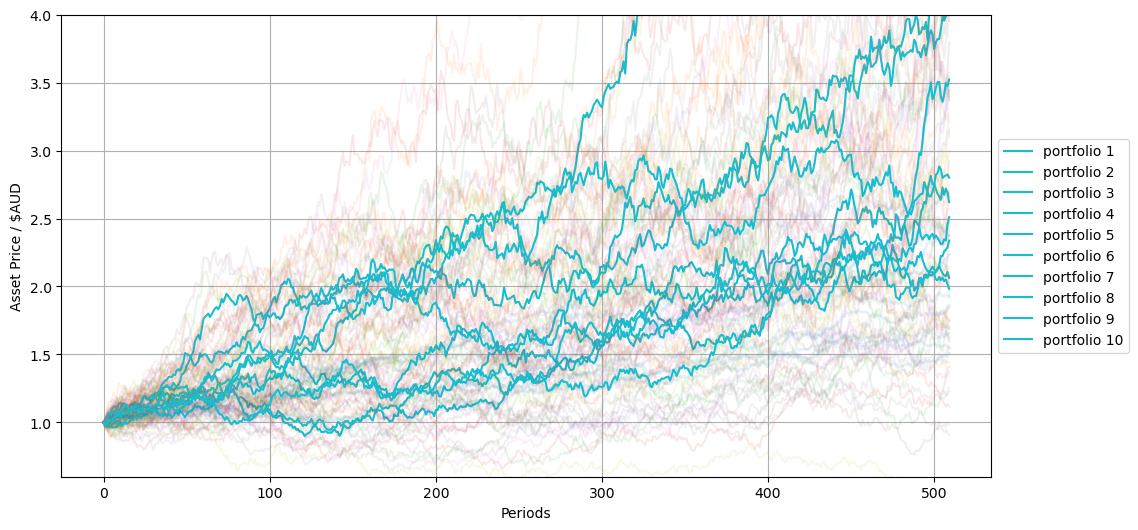

In [232]:
RISK_FREE = 0.02
AVERAGE = 0.07

RETURN = AVERAGE
STD = 0.4
FREQ = 51
YEARS = 10

def extra(beta):
    expected = (AVERAGE - RISK_FREE) * beta + RISK_FREE
    return expected - beta * RETURN

market = Market(RETURN / FREQ, STD / FREQ, 1)

unsystematic = 0.45
share1 = Equity(extra(0) / FREQ, 0, 0.2 / FREQ)
share1.alias = 'riskfree'
share4 = Equity(extra(0.7) / FREQ, 0.7, 0.40 / FREQ)
share4.alias = 'moderate'
share2 = Equity(extra(1) / FREQ, 1, 0.45 / FREQ)
share2.alias = 'average'
share3 = Equity(extra(2.1) / FREQ, 2.1, 1 / FREQ)
share3.alias = 'risky'
share5 = Equity(extra(-0.1) / FREQ, -0.1, 0.3 / FREQ)
share5.alias = 'gold'

# graph = Graphing(market, [share4, share4, share4, share4, share3, share3, share3, share3, share3, share3])
graph = Graphing(market, [share3, share3, share3, share3, share3, share3, share3, share3])
graph.show(YEARS * FREQ, 10)
# graph.show(YEARS * FREQ, 10)

# extra(1.4)